## 情感分析

简述：一直想拿LSTM练练文本分类，于是有了此文

- 数据来源及描述：不知道什么时候搜集到的关于美的热水器评价数据集（电商领域）,其中约3.9W条情感倾向正例样本，6000条情感倾向负例样本

- 基本思路：
    
    1、首先查看数据分布，利用matplotlib可视化句子词数分布情况；
    
    2、利用jieba分词工具，完成分词、清理停用词等操作；
    
    3、利用gensim中Word2vec工具，完成词向量转换工作，并简要介绍word2vec语义近似功能（这里的语义近似并非语文学科中的近义词概念，而是在词向量空间中计算出余弦夹角近似）；
    
    4、为了能顺利进入LSTM模型，使用词数中位数作为截断依据，让序列长度保持一致；
    
    5、将处理好的数据导入LSTM模型中迭代100次，观察LOSS变化情况，并预测其情感倾向分类,最终计算大约有89.12%准确率，证明效果还不错

- 参考文章：
    
    参考文章推荐两篇，一篇偏重理论，一篇偏重实践
    
    1、想看LSTM公式推导的小伙伴们看这篇<a href="http://blog.csdn.net/u010754290/article/details/47167979">LSTM公式推导</a>  。这篇文档描述LSTM模型我觉得是目前看起来公式写的最清晰，图画得最明白的一篇，想要彻底吃透LSTM，把这个博客中的公式跟着推一遍，应该会有很大收获；
    
    2、实践的话，我参考这篇文章<a href="http://blog.csdn.net/churximi/article/details/61210129">LSTM+词向量文本分类</a>  结合自己的理解，完成了此篇LSTM情感分析工作

### 依赖环境：

- 系统环境： win7环境（linux mac应该也能运行）

- python3

- keras(backend: Tensorflow)

- pandas

- jieba

- gensim

- re

### 引入相关库

In [1]:
import keras
import pandas as pd 
import jieba
from keras.preprocessing import sequence
from keras.optimizers import SGD, RMSprop, Adagrad
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.embeddings import Embedding
from keras.layers.recurrent import LSTM, GRU
import gensim
import re

Using TensorFlow backend.
d:\Anaconda3\lib\site-packages\gensim\utils.py:860: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


### 1、读入数据

In [2]:
data_neg = pd.read_csv('./input/meidi_jd_neg.txt',header=-1)
data_neg['flag']=0
data_neg.columns=['words','flag']

#### 情感倾向为负的评论

In [3]:
data_neg.head(5)

,words,flag
0,好像遥控是坏的 还是送的电池没有电 算了 热水器上将就着按吧,0
1,要打十个字才能发 我就打十个字,0
2,调温的开关太紧了 不知道是不是都这样 送货和安装的师傅来的很准时 不像以前要等老半天,0
3,上面安装既然花了我差不多*块 但是这热水器马马虎虎吧,0
4,这东西有不是什么高科技 比别的厂家还贵 想不明白,0


#### 情感倾向为正的评论

In [4]:
data_pos = pd.read_csv('./input/meidi_jd_pos.txt',header=-1)
data_pos['flag']=1
data_pos.columns =['words','flag']
data_pos.head(5)

,words,flag
0,还好 安装费有点贵,1
1,商品已经收到 打开包装检查一下外观完美；还没有安装使用 用后再评论,1
2,东西不错 租房子用的 足够了,1
3,很好 今天安装好了 非常满意,1
4,可以把 能用就好 出租的,1


#### 读入停用词

In [7]:
stop = pd.read_csv('./input/stoplist.txt',sep='timp',encoding='utf8')

d:\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  if __name__ == '__main__':


In [20]:
stop_list = list(stop.iloc[:,0])

#### 记录标点符号集合，将标点符号也作为停用词中一部分

In [21]:
import string
desl =string.punctuation
desl = desl+"、（）"

#### 将正负例数据拼接在一起

In [22]:
data_combine = pd.concat([data_neg,data_pos],axis=0)

#### 利用正则表达式替换标点符号, 不明白正则表达式的请移步<a href="http://www.runoob.com/python/python-reg-expressions.html">正则表达式链接</a>  ，在这里只需要明白re.sub命令即可

In [23]:
data_combine['words_punc'] = data_combine['words'].apply(lambda s :  re.sub(r'[%s]+'%desl,"",s))

In [24]:
data_combine['words_cuts'] = data_combine['words_punc'].apply(lambda s : list(jieba.cut(s))) 

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\Lenovo\AppData\Local\Temp\jieba.cache
Loading model cost 1.182 seconds.
Prefix dict has been built succesfully.


#### 去除停用词

In [25]:
data_combine['words_cuts_stop'] = data_combine['words_cuts'].apply(lambda s : [ i for i in s if i not in stop_list+[","," "]])

In [26]:
data_combine.head(2)

,words,flag,words_punc,words_cuts,words_cuts_stop
0,好像遥控是坏的 还是送的电池没有电 算了 热水器上将就着按吧,0,好像遥控是坏的 还是送的电池没有电 算了 热水器上将就着按吧,"[好像, 遥控, 是, 坏, 的, , 还是, 送, 的, 电池, 没有, 电, , 算...","[好像, 遥控, 是, 坏, 还是, 送, 电池, 没有, 电, 算了, 热水器, 上将, ..."
1,要打十个字才能发 我就打十个字,0,要打十个字才能发 我就打十个字,"[要, 打, 十个, 字, 才能, 发, , 我, 就, 打, 十个, 字]","[要, 打, 十个, 字, 才能, 发, 我, 就, 打, 十个, 字]"


### 数据探索

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt 

In [29]:
data_combine['lenth'] = data_combine['words_cuts_stop'].apply(lambda s:len(s))

In [30]:
%matplotlib inline

#### 绘制正向、负向语言分布词数分布情况

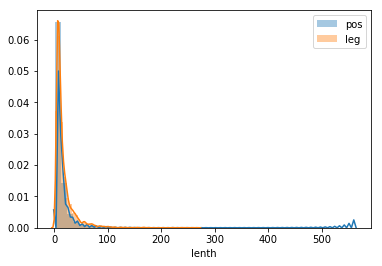

In [31]:
plt.figure(figsize=(6,4))
sns.distplot(data_combine[data_combine['flag']==1]['lenth'],label='pos')
sns.distplot(data_combine[data_combine['flag']==0]['lenth'],label='neg')
plt.legend(['pos','leg'])

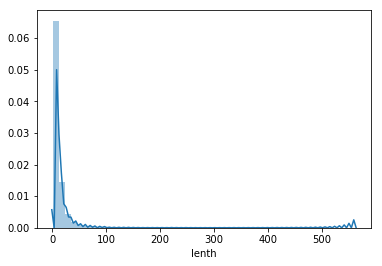

In [33]:
sns.distplot(data_combine[data_combine['flag']==1]['lenth'],label='pos')

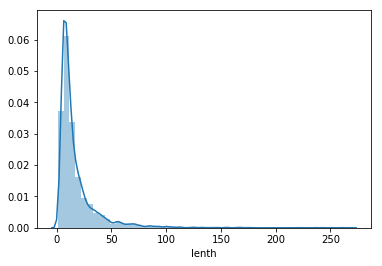

In [34]:
sns.distplot(data_combine[data_combine['flag']==0]['lenth'],label='neg')

#### 正负向语料比例情况

(array([0, 1]), <a list of 2 Text xticklabel objects>)

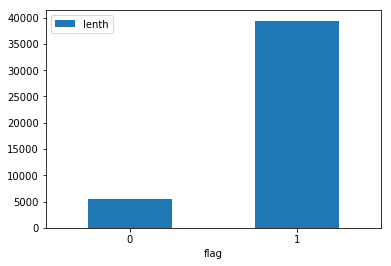

In [35]:
data_combine.pivot_table(index='flag',aggfunc={'lenth':'count'}).plot(kind='bar')
plt.xticks(rotation=0)

#### 情感倾向正负向语料长度中位数分布情况，看起来评价负面的话比较多  嗯嗯呃

(array([0, 1]), <a list of 2 Text xticklabel objects>)

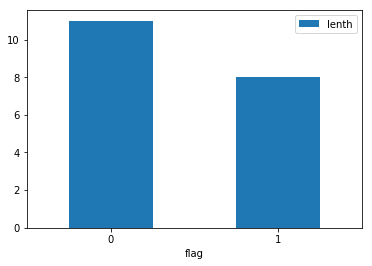

In [36]:
data_combine.pivot_table(index='flag',aggfunc={'lenth':'median'}).plot(kind='bar')
plt.xticks(rotation=0)

### 制作词云

In [37]:
from wordcloud import WordCloud

In [38]:
data_combine.head(2)

,words,flag,words_punc,words_cuts,words_cuts_stop,lenth
0,好像遥控是坏的 还是送的电池没有电 算了 热水器上将就着按吧,0,好像遥控是坏的 还是送的电池没有电 算了 热水器上将就着按吧,"[好像, 遥控, 是, 坏, 的, , 还是, 送, 的, 电池, 没有, 电, , 算...","[好像, 遥控, 是, 坏, 还是, 送, 电池, 没有, 电, 算了, 热水器, 上将, ...",16
1,要打十个字才能发 我就打十个字,0,要打十个字才能发 我就打十个字,"[要, 打, 十个, 字, 才能, 发, , 我, 就, 打, 十个, 字]","[要, 打, 十个, 字, 才能, 发, 我, 就, 打, 十个, 字]",11


In [39]:
data_combine['space_words'] = data_combine['words_cuts_stop'].apply(lambda s : ' '.join(s))

#### 为了解决乱码问题，指定字体文件，字体文件，搜索微软雅黑字体，需要大家自行下载，放在指定目录下，这里放在C:\Windows\fonts2 下了

In [25]:
font = r'C:\Windows\fonts2\msyh.ttf'

##### 情感评论为负面的评价 大家主要在说些什么

(-0.5, 1239.5, 879.5, -0.5)

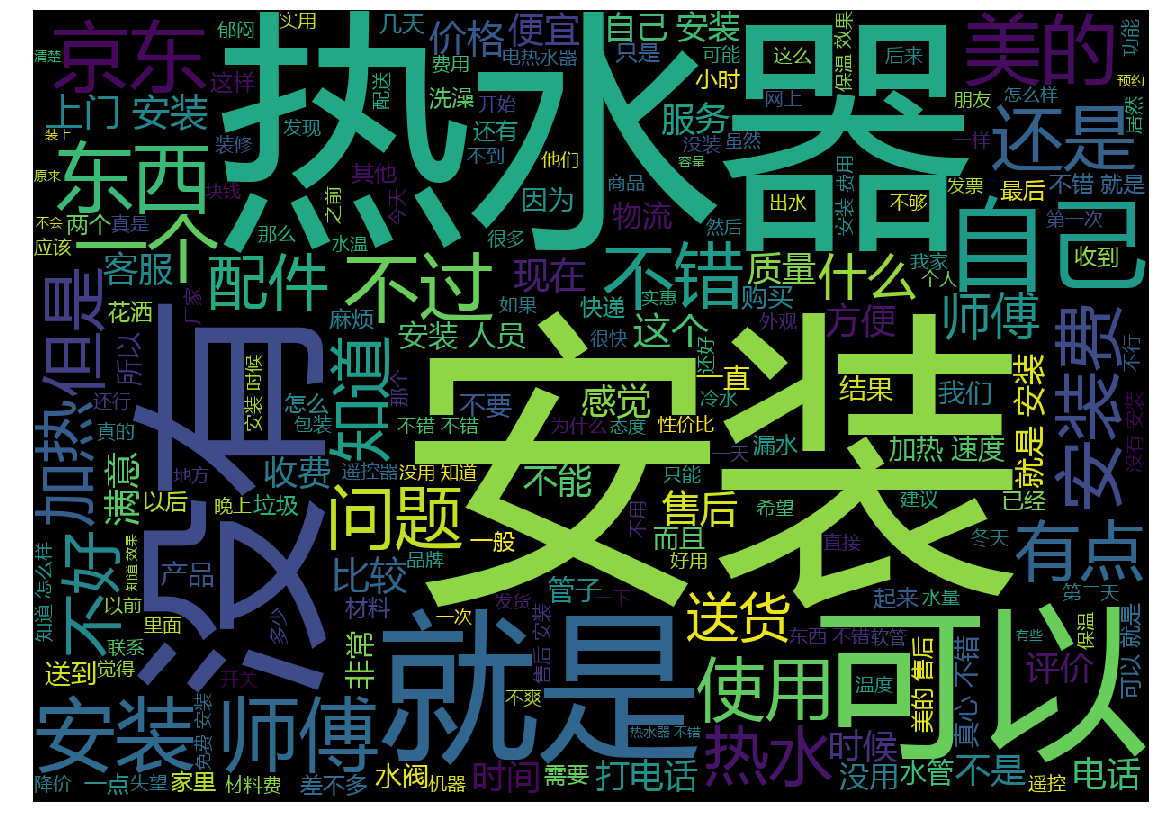

In [26]:
cloud = WordCloud(width=1240, font_path=font,height=880).generate((' '.join(data_combine[data_combine['flag']==0]['space_words'])))
plt.figure(figsize=(20, 15))
plt.imshow(cloud)
plt.axis('off')

##### 评价为正面的伙伴们在说些什么

(-0.5, 1239.5, 879.5, -0.5)

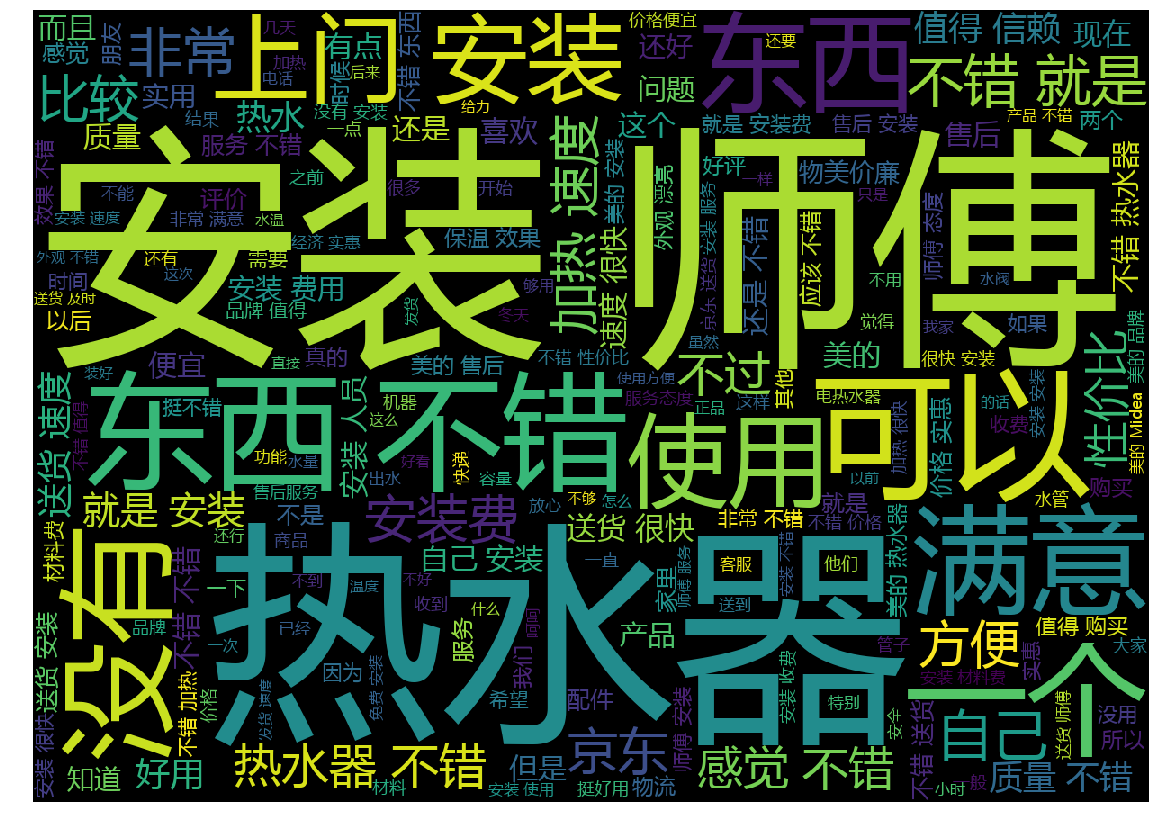

In [27]:
cloud = WordCloud(width=1240, font_path=font,height=880).generate((' '.join(data_combine[data_combine['flag']==1]['space_words'])))
plt.figure(figsize=(20, 15))
plt.imshow(cloud)
plt.axis('off')

### Word2vec

In [40]:
from gensim.models import Word2Vec

#### Word2vec初步使用 ，这里设定最小次数为3才纳入词典，最后输出词向量维度为60，这些参数可以自行根据情况调整

In [42]:
emotion_w2v = Word2Vec(data_combine['words_cuts_stop'],min_count=3,size=60)

#### 热水器 在语义空间上与各个词之间的相似性

In [43]:
emotion_w2v.most_similar(u'热水器')

[('机器', 0.5852192640304565),
 ('机子', 0.5446995496749878),
 ('东西', 0.49695444107055664),
 ('一档', 0.49490752816200256),
 ('觉得', 0.4857451319694519),
 ('奇怪的是', 0.4810256063938141),
 ('狭窄', 0.47884035110473633),
 ('对得起', 0.4785222113132477),
 ('这价', 0.4693329632282257),
 ('款', 0.4662902355194092)]

In [44]:
emotion_w2v.similarity(u'热水器',u'办公室')

0.45923745472791311

###  进入模型前的数据预处理

In [51]:
from sklearn.cross_validation import  train_test_split

d:\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [36]:
data_combine.lenth.describe()

count    44865.000000
mean        13.137635
std         16.481689
min          1.000000
25%          6.000000
50%          8.000000
75%         14.000000
max        562.000000
Name: lenth, dtype: float64

#### 为了避免太多字符串为空，确定字符串长度为16（依据: 大概80%分位数吧）

In [45]:
data_combine.head(2)

,words,flag,words_punc,words_cuts,words_cuts_stop,lenth,space_words
0,好像遥控是坏的 还是送的电池没有电 算了 热水器上将就着按吧,0,好像遥控是坏的 还是送的电池没有电 算了 热水器上将就着按吧,"[好像, 遥控, 是, 坏, 的, , 还是, 送, 的, 电池, 没有, 电, , 算...","[好像, 遥控, 是, 坏, 还是, 送, 电池, 没有, 电, 算了, 热水器, 上将, ...",16,好像 遥控 是 坏 还是 送 电池 没有 电 算了 热水器 上将 就 着 按 吧
1,要打十个字才能发 我就打十个字,0,要打十个字才能发 我就打十个字,"[要, 打, 十个, 字, 才能, 发, , 我, 就, 打, 十个, 字]","[要, 打, 十个, 字, 才能, 发, 我, 就, 打, 十个, 字]",11,要 打 十个 字 才能 发 我 就 打 十个 字


In [47]:
def return_w2v_value(s):
    try :
        return emotion_w2v[s]
    except:
        return [0]*60
def modify_words_lenth(s):
    if len(s)<=16:
        return s +['         ']*(16-len(s))
    else:
        return s[:16]

####  不足16个词的先补齐16个词，超过16个词的截取16个词
#### 把截取后的词按照训练好的w2v词向量转换

In [48]:
data_combine['words_cuts_stop_modify'] = data_combine['words_cuts_stop'].apply(lambda s : modify_words_lenth(s))
data_combine['words_trans_w2v'] = data_combine['words_cuts_stop_modify'].apply(lambda s : [return_w2v_value(i) for i in s])

In [49]:
data_combine.head(2)

,words,flag,words_punc,words_cuts,words_cuts_stop,lenth,space_words,words_cuts_stop_modify,words_trans_w2v
0,好像遥控是坏的 还是送的电池没有电 算了 热水器上将就着按吧,0,好像遥控是坏的 还是送的电池没有电 算了 热水器上将就着按吧,"[好像, 遥控, 是, 坏, 的, , 还是, 送, 的, 电池, 没有, 电, , 算...","[好像, 遥控, 是, 坏, 还是, 送, 电池, 没有, 电, 算了, 热水器, 上将, ...",16,好像 遥控 是 坏 还是 送 电池 没有 电 算了 热水器 上将 就 着 按 吧,"[好像, 遥控, 是, 坏, 还是, 送, 电池, 没有, 电, 算了, 热水器, 上将, ...","[[0.116414, 0.620244, -0.984428, -0.027382, 0...."
1,要打十个字才能发 我就打十个字,0,要打十个字才能发 我就打十个字,"[要, 打, 十个, 字, 才能, 发, , 我, 就, 打, 十个, 字]","[要, 打, 十个, 字, 才能, 发, 我, 就, 打, 十个, 字]",11,要 打 十个 字 才能 发 我 就 打 十个 字,"[要, 打, 十个, 字, 才能, 发, 我, 就, 打, 十个, 字, ...","[[0.345645, 2.26546, -1.03312, -0.443616, 1.51..."


### 分割数据集

In [52]:
x_train,x_test,y_train,y_test = train_test_split(data_combine['words_trans_w2v'],data_combine['flag'],test_size=0.2)

In [53]:
import numpy as np 

#### 这里需要将特征数据x转换成  N× L×M 维度， 其中N 代表语句个数，L代表每句话长度，M代表每句话中每个词对应的词向量长度，目标数据y 转换成 N× class维度，其中N代表语句个数， class代表分类个数，这里情感分析只有两类 ，所以取2

In [54]:
x_train_modify = np.array(list(x_train))

In [55]:
x_test_modify = np.array(list(x_test))

In [56]:
y_train_modify = np.array(pd.get_dummies(y_train))
y_test_modify = np.array(pd.get_dummies(y_test))

In [57]:
x_train_modify.shape, x_test_modify.shape, y_train_modify.shape , y_test_modify.shape

((35892, 16, 60), (8973, 16, 60), (35892, 2), (8973, 2))

In [81]:
x_train_modify.shape

(35892, 16, 60)

#### 建立模型训练。。。。。耗时可能比较长，如果需要快速查看效果  可以将nb_epoch参数修改小一点

In [103]:
model = Sequential()
model.add(LSTM(22, input_shape=(16,60),dropout=0.5,activation='sigmoid'))
model.add(Dense(2, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())
print('Fit Model..')
#  神经网络训练
history = model.fit(x_train_modify,y_train_modify,batch_size=64,nb_epoch=100)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_21 (LSTM)               (None, 22)                7304      
_________________________________________________________________
dense_22 (Dense)             (None, 2)                 46        
Total params: 7,350
Trainable params: 7,350
Non-trainable params: 0
_________________________________________________________________
None
Fit Model..


d:\Anaconda3\lib\site-packages\keras\models.py:848: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Epoch 1/100
35892/35892 [==============================] - 12s - loss: 0.3521 - acc: 0.8783    
Epoch 2/100
35892/35892 [==============================] - 12s - loss: 0.3127 - acc: 0.8781    
Epoch 3/100
35892/35892 [==============================] - 11s - loss: 0.3048 - acc: 0.8786    
Epoch 4/100
35892/35892 [==============================] - 12s - loss: 0.3027 - acc: 0.8793    
Epoch 5/100
35892/35892 [==============================] - 12s - loss: 0.3006 - acc: 0.8818    
Epoch 6/100
35892/35892 [==============================] - 12s - loss: 0.2986 - acc: 0.8818    
Epoch 7/100
35892/35892 [==============================] - 12s - loss: 0.2970 - acc: 0.8820    
Epoch 8/100
35892/35892 [==============================] - 11s - loss: 0.2942 - acc: 0.8824    
Epoch 9/100
35892/35892 [==============================] - 11s - loss: 0.2932 - acc: 0.8832    
Epoch 10/100
35892/35892 [==============================] - 11s - loss: 0.2916 - acc: 0.8836    
Epoch 11/100
35892/35892 [=============

In [97]:
from matplotlib import pyplot

In [106]:
import matplotlib as mpl
mpl.rcParams['font.sans-serif'] = ['Microsoft YaHei']#指定默认字体  
mpl.rcParams['axes.unicode_minus'] =False # 解决保存图像是负号'-'显示为方块的问题
#sns.axes_style()，可以看到是否成功设定字体为微软雅黑。

# 最后：修改seaborn中的一些设置
sns.set_context("talk")

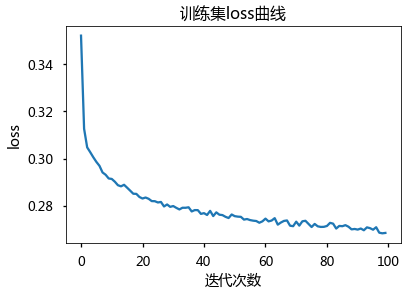

In [108]:
pyplot.plot(history.history['loss'], label='train')
plt.title(u'训练集loss曲线')
plt.xlabel(u'迭代次数')
plt.ylabel(u'loss')
# pyplot.plot(history.history['acc'], label='acc')

In [87]:
from sklearn.metrics import  accuracy_score

### 计算预测结果

In [111]:
prediction = [np.argmax(i) for i in model.predict(x_test_modify)]

### 计算精确率

In [112]:
accuracy_score(prediction,y_test)

0.89122924328541175

#### 结论：

- 最终精确率能达到89.12%，貌似比网上参考资料要高一些，或许word2vec比keras自带的embding方法效果会好些；

- 如果想要进一步提高准确度，词典制作，停用词词表可能还需要进一步整理，建立word2vec的时候，语句长度，输出维度参数可以进一步调参试试